In [1]:
%matplotlib inline

import cv2, matplotlib
import numpy as np
from skimage.morphology import (
    skeletonize,
    skeletonize_3d,
    medial_axis,
    thin,
    local_minima,
    local_maxima,
)
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import distance_transform_edt

from math import sqrt

import matplotlib.pyplot as plt

from os.path import expanduser, splitext
from os import scandir, makedirs

# import random

import csv

from tqdm import tnrange, tqdm_notebook

from pathlib import Path

debug = True  # plot every steps

# import floorplan analysis

In [2]:
from floorplan_analysis import read_bgr_from_image_unicode, get_unit_mask
from floorplan_analysis import rescale_fp
from floorplan_analysis import mono_fp, fp_float_from_mono, fp_uint8_from_mono
from floorplan_analysis import pad_fp

# normalization

In [3]:
import pandas as pd

path_csv = "fp_refined.csv"

df = pd.read_csv(path_csv)
df = df.set_index("id_after")
df.Area

id_after
8928_160      134.30
8928_183      153.80
8928_201A     170.32
8928_204B     168.42
960_35         35.64
               ...  
115454_21D     14.50
115454_34E     21.57
115454_36B     24.86
115454_37A     25.67
115454_38C     25.21
Name: Area, Length: 50540, dtype: float64

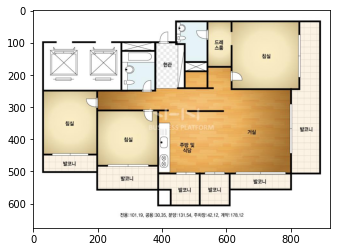

In [85]:
id_ = "27297_131"
bgr = read_bgr_from_image_unicode(f"/fp_img/{id_}.jpg")

# 101160_113E 85
# 103915_112C 85
# 104127_107B 80
# 107903_113G 85
# 108838_117B 85

# 방향 오류 (였던 것)
# 1998_53B
# 13193_113C
# 27874_132A
# 100105_144F1
# 27297_131

# 정상
# 19778_43
# 422_58
# 105975_42C12

# 발코니 없음
# 5520_150
# 101305_96T

# 용인
# 27677_169


plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

In [86]:
df.Area[id_]

101.2

In [87]:
unit_comb_orig = get_unit_mask(bgr)

In [88]:
fp = rescale_fp(unit_comb_orig, df.Area[id_])
fp = mono_fp(fp)
fp = fp_uint8_from_mono(fp)

In [89]:
fp.shape

(56, 84, 6)

In [90]:
fp.sum(axis=(0, 1))

array([159885,  22440, 241485, 220830, 156570,  43095], dtype=uint64)

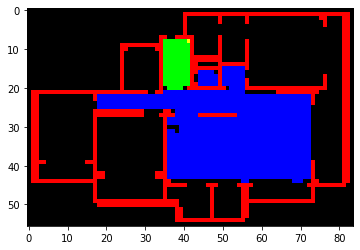

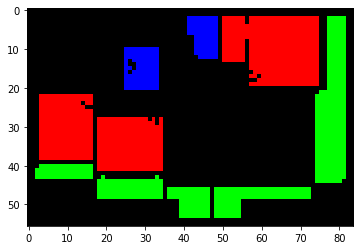

In [91]:
for i in range(0, fp.shape[2], 3):
    plt.figure()
    plt.imshow(fp[..., i : i + 3])

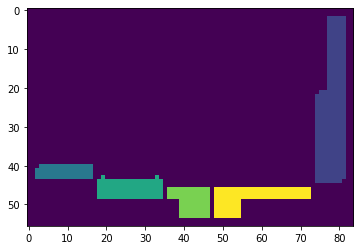

In [92]:
ret, markers = cv2.connectedComponents(fp[:, :, 4])
plt.imshow(markers)

In [93]:
np.unique(markers, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([4090,  285,   59,   87,   73,  110]))

In [94]:
d = 11
kernel = np.zeros((d, d, 4), np.uint8)
kernel[d // 2, : d // 2 + 1, 0] = 1  # right, means facing left
kernel[d // 2, d // 2 :, 1] = 1  # left, means facing right
kernel[: d // 2 + 1, d // 2, 2] = 1  # bottom, means facing top
kernel[d // 2 :, d // 2, 3] = 1  # top, means facing bottom

kernel[..., 1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

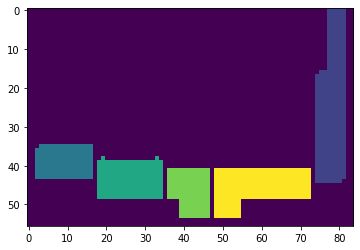

In [95]:
dilated = np.zeros(markers.shape + (4,), np.uint8)
for i in range(4):
    dilated[..., i] = cv2.dilate(markers.astype(np.uint8), kernel[..., i])

plt.imshow(dilated[..., 3])

발코니가 달리는 공간: LDK와 침실 (벽체, 현관, 화장실은 아님)

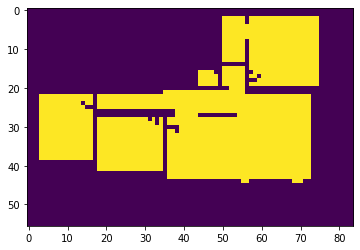

In [96]:
plt.imshow(np.bitwise_or.reduce(fp[..., 2:4], 2))

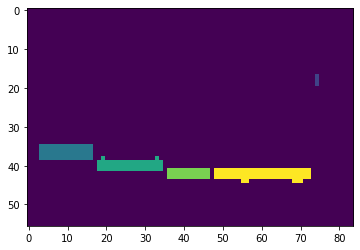

In [97]:
adjacent = dilated & np.expand_dims(np.bitwise_or.reduce(fp[..., 2:4], 2), 2)
plt.imshow(adjacent[..., 3])  # top, means facing bottom

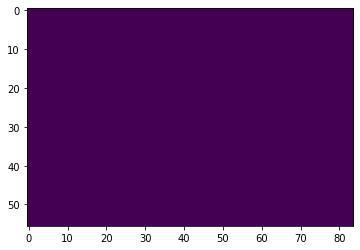

In [98]:
plt.imshow(adjacent[..., 2])  # bottom, means facing top

m00 면적, nu20 가로 길이, nu02 세로 길이

In [99]:
cv2.moments((markers == 1).astype(int), True)

{'m00': 285.0,
 'm10': 22230.0,
 'm01': 7220.0,
 'm20': 1735256.0,
 'm11': 561037.0,
 'm02': 223968.0,
 'm30': 135554430.0,
 'm21': 43632015.0,
 'm12': 17373805.0,
 'm03': 7614050.0,
 'mu20': 1316.0,
 'mu11': -2123.0,
 'mu02': 41061.33333333334,
 'mu30': -834.0,
 'mu21': 3384.3333333333358,
 'mu12': 11866.333333333023,
 'mu03': -140246.888888889,
 'nu20': 0.016201908279470607,
 'nu11': -0.026137273007079104,
 'nu02': 0.5055258028111215,
 'nu30': -0.0006082104820573506,
 'nu21': 0.0024680899377810895,
 'nu12': 0.008653750979520007,
 'nu03': -0.10227773129275164}

크기와 무관한 nu20 vs nu02

대각선은 거의 1:1 (0.133 vs 0.124)

짧아도 4배 이상은 차이 나고 거의 정사각형 같아야 1.5배 차이
2배로 잡으면 적당할 듯

In [100]:
list(range(1, ret))

[1, 2, 3, 4, 5]

In [101]:
moments = cv2.moments((markers == 1).astype(int), True)
moments["nu20"], moments["nu02"]

(0.016201908279470607, 0.5055258028111215)

In [102]:
(adjacent[..., 3] == 5).sum()

80

In [103]:
cv2.countNonZero((adjacent[..., 3] == 1).astype(np.uint8))

3

In [104]:
if moments["nu20"] / moments["nu02"] > 2:
    # horizontal = top or bottom
    if (adjacent[..., 2] == 1).sum() > (adjacent[..., 3] == 1).sum():
        # facing top
        print("top")
    else:
        # facing bottom
        print("bottom")

In [105]:
(markers == 1).shape

(56, 84)

In [106]:
np.bitwise_or.reduce((markers == 1), 0)  # reduce row = y

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True, False, False])

In [107]:
np.bitwise_or.reduce((markers == 1), 0).sum(), np.bitwise_or.reduce(
    (markers == 1), 1
).sum()

(8, 43)

In [108]:
sum_by_facing = [0, 0, 0, 0]
for i in range(1, ret):
    moments = cv2.moments((markers == i).astype(int), True)
    aspect = moments["nu20"] / moments["nu02"]
    if aspect > 2:
        # horizontal = top or bottom
        width = np.bitwise_or.reduce((markers == i), 0).sum()

        if (adjacent[..., 2] == i).sum() > (adjacent[..., 3] == i).sum():
            # facing top
            sum_by_facing[2] += width
        else:
            # facing bottom
            sum_by_facing[3] += width
    elif aspect < 0.5:
        # vertical = left or right
        width = np.bitwise_or.reduce((markers == i), 1).sum()

        if (adjacent[..., 0] == i).sum() > (adjacent[..., 1] == i).sum():
            # facing left
            sum_by_facing[0] += width
        else:
            # facing right
            sum_by_facing[1] += width
    else:
        # ignore
        pass
print(sum_by_facing)  # lrtb order

[0, 43, 0, 57]


In [109]:
# remove minor facing

sum_by_facing = [
    0 if width < max(sum_by_facing) / 2 else width for width in sum_by_facing
]
sum_by_facing

[0, 43, 0, 57]

# position of main bedroom

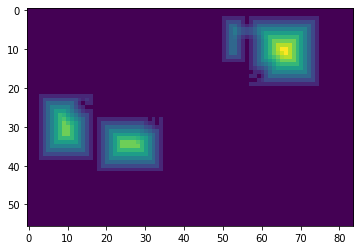

In [110]:
dist_transform = cv2.distanceTransform(fp[:, :, 3], cv2.DIST_L2, 5)
plt.imshow(dist_transform)

In [111]:
dist_transform.max()

9.0

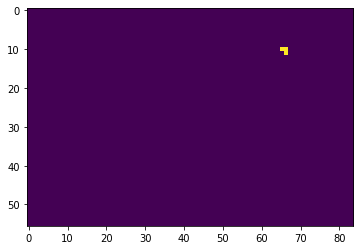

In [112]:
mbr_core = (dist_transform == dist_transform.max()).astype(np.uint8)
plt.imshow(mbr_core)

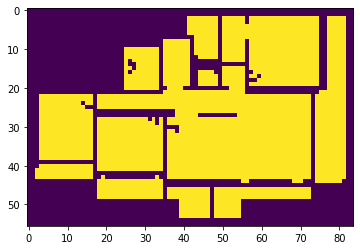

In [113]:
plt.imshow(np.bitwise_or.reduce(fp[..., 1:], 2))

In [114]:
moments = cv2.moments(np.bitwise_or.reduce(fp[..., 1:], 2), True)
center_h = round(moments["m10"] / moments["m00"])  # center of floorplan
center_h

47

In [115]:
moments = cv2.moments(np.bitwise_or.reduce(fp[..., 1:], 2), True)
center_v = round(moments["m01"] / moments["m00"])  # center of floorplan
center_v

28

In [116]:
mbr_core.shape, mbr_core[:, :center_h].shape, mbr_core[:, center_h:].shape

((56, 84), (56, 47), (56, 37))

In [117]:
mbr_core[:, :center_h].sum(), mbr_core[:, center_h:].sum()

(0, 3)

In [118]:
mbr_core[:center_v, :].sum(), mbr_core[center_v:, :].sum()  # top, bottom

(3, 0)

In [119]:
mbr_left = mbr_core[:, :center_h].sum()
mbr_right = mbr_core[:, center_h:].sum()

if mbr_left > mbr_right:
    print("left")
elif mbr_left < mbr_right:
    print("right")
else:
    print("error")

right


In [120]:
def mbr_position(fp):
    # center of floorplan
    moments = cv2.moments(np.bitwise_or.reduce(fp[..., 1:], 2), True)
    center = (
        round(moments["m10"] / moments["m00"]),  # x
        round(moments["m01"] / moments["m00"]),  # y
    )

    # core of main bedroom
    dist_transform = cv2.distanceTransform(fp[:, :, 3], cv2.DIST_L2, 5)
    mbr_core = (dist_transform == dist_transform.max()).astype(np.uint8)

    # horizontal
    mbr_left = mbr_core[:, : center[0]].sum()
    mbr_right = mbr_core[:, center[0] :].sum()

    if mbr_left > mbr_right:
        horizontal = "left"
    elif mbr_left < mbr_right:
        horizontal = "right"
    else:
        horizontal = "not sure"

    # vertical
    mbr_top = mbr_core[: center[1], :].sum()
    mbr_bottom = mbr_core[center[1] :, :].sum()

    if mbr_top > mbr_bottom:
        vertical = "top"
    elif mbr_top < mbr_bottom:
        vertical = "bottom"
    else:
        vertical = "not sure"

    return horizontal, vertical

In [121]:
mbr_position(fp)

('right', 'top')

# pick one from opposite facings

In [122]:
horizontal, vertical = mbr_position(fp)

if sum_by_facing[0] and sum_by_facing[1]:  # if left and right are both valid
    if horizontal == "left":
        sum_by_facing[1] = 0
    elif horizontal == "right":
        sum_by_facing[0] = 0
    else:
        if sum_by_facing[0] > sum_by_facing[1]:
            sum_by_facing[1] = 0
        else:
            sum_by_facing[0] = 0

if sum_by_facing[2] and sum_by_facing[3]:  # if top and bottom are both valid
    if vertical == "top":
        sum_by_facing[3] = 0
    elif vertical == "bottom":
        sum_by_facing[2] = 0
    else:
        if sum_by_facing[2] > sum_by_facing[3]:
            sum_by_facing[3] = 0
        else:
            sum_by_facing[2] = 0

In [123]:
sum_by_facing

[0, 43, 0, 57]

In [124]:
["left", "right", "top", "bottom"][sum_by_facing.index(max(sum_by_facing))]

'bottom'

# facing detection by balcony, final

In [125]:
def balcony_per_facing(fp):
    """balcony width by facing
    returns list of total widths of balconies
    facing left, right, top, bottom"""

    # get connected balcony zones

    ret, markers = cv2.connectedComponents(fp[:, :, 4])

    # get adjacent areas per balcony

    d = 11
    kernel = np.zeros((d, d, 4), np.uint8)
    kernel[d // 2, : d // 2 + 1, 0] = 1  # right, means facing left
    kernel[d // 2, d // 2 :, 1] = 1  # left, means facing right
    kernel[: d // 2 + 1, d // 2, 2] = 1  # bottom, means facing top
    kernel[d // 2 :, d // 2, 3] = 1  # top, means facing bottom

    dilated = np.zeros(markers.shape + (4,), np.uint8)
    for i in range(4):
        dilated[..., i] = cv2.dilate(markers.astype(np.uint8), kernel[..., i])
    adjacent = dilated & np.expand_dims(np.bitwise_or.reduce(fp[..., 2:4], 2), 2)

    # get sum by facing

    sum_by_facing = [0, 0, 0, 0]
    for i in range(1, ret):
        moments = cv2.moments((markers == i).astype(int), True)
        aspect = moments["nu20"] / moments["nu02"]
        if aspect > 2:
            # horizontal = top or bottom
            width = np.bitwise_or.reduce((markers == i), 0).sum()

            if (adjacent[..., 2] == i).sum() > (adjacent[..., 3] == i).sum():
                # facing top
                sum_by_facing[2] += width
            else:
                # facing bottom
                sum_by_facing[3] += width
        elif aspect < 0.5:
            # vertical = left or right
            width = np.bitwise_or.reduce((markers == i), 1).sum()

            if (adjacent[..., 0] == i).sum() > (adjacent[..., 1] == i).sum():
                # facing left
                sum_by_facing[0] += width
            else:
                # facing right
                sum_by_facing[1] += width
        else:
            # ignore
            pass

    return sum_by_facing  # lrtb


def facing_by_balcony(sum_by_facing, mbr_position):

    assert any(sum_by_facing), "no balcony"

    # remove minor facing

    sum_by_facing = [
        0 if width < max(sum_by_facing) / 2 else width for width in sum_by_facing
    ]

    # remove opposite

    horizontal, vertical = mbr_position

    if sum_by_facing[0] and sum_by_facing[1]:  # if left and right are both valid
        if horizontal == "left":
            sum_by_facing[1] = 0
        elif horizontal == "right":
            sum_by_facing[0] = 0
        else:
            if sum_by_facing[0] > sum_by_facing[1]:
                sum_by_facing[1] = 0
            else:
                sum_by_facing[0] = 0

    if sum_by_facing[2] and sum_by_facing[3]:  # if top and bottom are both valid
        if vertical == "top":
            sum_by_facing[3] = 0
        elif vertical == "bottom":
            sum_by_facing[2] = 0
        else:
            if sum_by_facing[2] > sum_by_facing[3]:
                sum_by_facing[3] = 0
            else:
                sum_by_facing[2] = 0

    # return facing with most balcony
    return sum_by_facing.index(max(sum_by_facing))  # lrtb

In [126]:
# 방향 오류 (였던 것)
# 1998_53B
# 13193_113C
# 27874_132A
# 100105_144F1
# 27297_131

# 정상
# 19778_43
# 422_58
# 105975_42C12

bottom


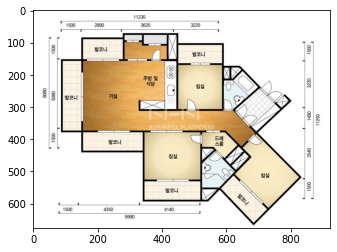

In [127]:
id_ = "13193_113C"
bgr = read_bgr_from_image_unicode(f"/fp_img/{id_}.jpg")
unit_comb_orig = get_unit_mask(bgr)
fp = rescale_fp(unit_comb_orig, df.Area[id_])
fp = mono_fp(fp)
fp = fp_uint8_from_mono(fp)

plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

bal_per_facing = balcony_per_facing(fp)
if any(bal_per_facing):
    facing = facing_by_balcony(bal_per_facing, mbr_position(fp))
    print(["left", "right", "top", "bottom"][facing])
else:
    print("no balcony")

# no balcony

In [47]:
# 발코니 없음
# 5520_150
# 101305_96T
# 104168_116B
# 106068_31H1
# 106449_41E
# 109582_52C

# 소형
# 422_58
# 8844_57

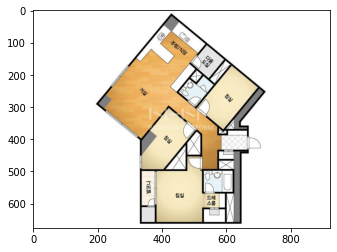

In [48]:
id_ = "104168_116B"
bgr = read_bgr_from_image_unicode(f"/fp_img/{id_}.jpg")
unit_comb_orig = get_unit_mask(bgr)
fp = rescale_fp(unit_comb_orig, df.Area[id_])
fp = mono_fp(fp)
fp = fp_uint8_from_mono(fp)

plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))

In [49]:
d = 5
kernel = np.zeros((d, d, 2), np.uint8)
kernel[d // 2, :, 0] = 1  # horizontal, for horizontal walls, means facing left or right
kernel[:, d // 2, 1] = 1  # vertical, for vertical walls, means facing top or bottom


print(kernel[..., 0])
print(kernel[..., 1])

[[0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]


In [50]:
erosion = np.zeros(fp.shape[:2] + (2,), np.uint8)
for i in range(2):
    erosion[..., i] = cv2.erode(fp[..., 0], kernel[..., i])

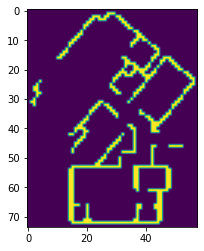

In [51]:
plt.imshow(fp[..., 0])

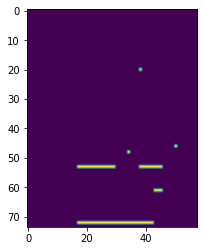

In [52]:
plt.imshow(erosion[..., 0])

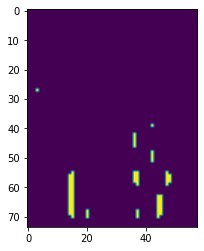

In [53]:
plt.imshow(erosion[..., 1])

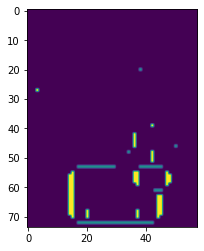

In [54]:
plt.imshow(erosion[..., 0] & 128 | erosion[..., 1])

In [55]:
cv2.countNonZero(erosion[..., 0]), cv2.countNonZero(erosion[..., 1])

(53, 79)

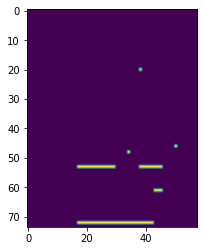

In [56]:
plt.imshow(skeletonize(erosion[..., 0] > 0))

In [57]:
skeletonize(erosion[..., 0] > 0).sum()

53

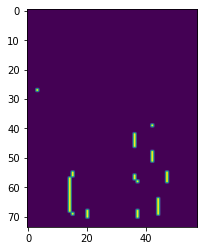

In [58]:
plt.imshow(skeletonize(erosion[..., 1] > 0))

In [59]:
skeletonize(erosion[..., 1] > 0).sum()

45

In [60]:
["left/right", "top/bottom"][
    0
    if skeletonize(erosion[..., 0] > 0).sum() > skeletonize(erosion[..., 1] > 0).sum()
    else 1
]

'left/right'

In [61]:
def ent_position(fp):
    # center of floorplan
    moments = cv2.moments(np.bitwise_or.reduce(fp[..., 1:], 2), True)
    center = (
        round(moments["m10"] / moments["m00"]),  # x
        round(moments["m01"] / moments["m00"]),  # y
    )

    # core of entrance
    dist_transform = cv2.distanceTransform(fp[:, :, 1], cv2.DIST_L2, 5)
    core = (dist_transform == dist_transform.max()).astype(np.uint8)

    # horizontal
    left = core[:, : center[0]].sum()
    right = core[:, center[0] :].sum()

    if left > right:
        horizontal = "left"
    elif left < right:
        horizontal = "right"
    else:
        horizontal = "not sure"

    # vertical
    top = core[: center[1], :].sum()
    bottom = core[center[1] :, :].sum()

    if top > bottom:
        vertical = "top"
    elif top < bottom:
        vertical = "bottom"
    else:
        vertical = "not sure"

    return horizontal, vertical

In [62]:
ent_position(fp)

('right', 'bottom')

In [63]:
def facing_by_wall(fp):
    d = 5
    kernel = np.zeros((d, d, 2), np.uint8)
    kernel[
        d // 2, :, 0
    ] = 1  # horizontal, for horizontal walls, means facing left or right
    kernel[:, d // 2, 1] = 1  # vertical, for vertical walls, means facing top or bottom

    erosion = np.zeros(fp.shape[:2] + (2,), np.uint8)
    for i in range(2):
        erosion[..., i] = cv2.erode(fp[..., 0], kernel[..., i])

    wall_h = skeletonize(erosion[..., 0] > 0).sum()
    wall_v = skeletonize(erosion[..., 1] > 0).sum()

    horizontal, vertical = ent_position(fp)
    if wall_h > wall_v:
        # left or right
        if horizontal == "left":
            facing = 1  # right
        elif horizontal == "right":
            facing = 0  # left
        else:
            facing = -1  # not sure
    else:
        # top or bottom
        if vertical == "top":
            facing = 3  # top
        elif vertical == "bottom":
            facing = 2  # bottom
        else:
            facing = -1  # not sure

    return facing  # lrtb

In [64]:
["left", "right", "top", "bottom"][facing_by_wall(fp)]

'left'

In [65]:
def align_fp(fp):  # rescale first
    """put the main side to down and entrance to left"""

    def mbr_position(fp):
        # center of floorplan
        moments = cv2.moments(np.bitwise_or.reduce(fp[..., 1:], 2), True)
        center = (
            round(moments["m10"] / moments["m00"]),  # x
            round(moments["m01"] / moments["m00"]),  # y
        )

        # core of main bedroom
        dist_transform = cv2.distanceTransform(fp[:, :, 3], cv2.DIST_L2, 5)
        mbr_core = (dist_transform == dist_transform.max()).astype(np.uint8)

        # horizontal
        mbr_left = mbr_core[:, : center[0]].sum()
        mbr_right = mbr_core[:, center[0] :].sum()

        if mbr_left > mbr_right:
            horizontal = "left"
        elif mbr_left < mbr_right:
            horizontal = "right"
        else:
            horizontal = "not sure"

        # vertical
        mbr_top = mbr_core[: center[1], :].sum()
        mbr_bottom = mbr_core[center[1] :, :].sum()

        if mbr_top > mbr_bottom:
            vertical = "top"
        elif mbr_top < mbr_bottom:
            vertical = "bottom"
        else:
            vertical = "not sure"

        return horizontal, vertical

    def ent_position(fp):
        # center of floorplan
        moments = cv2.moments(np.bitwise_or.reduce(fp[..., 1:], 2), True)
        center = (
            round(moments["m10"] / moments["m00"]),  # x
            round(moments["m01"] / moments["m00"]),  # y
        )

        # core of entrance
        dist_transform = cv2.distanceTransform(fp[:, :, 1], cv2.DIST_L2, 5)
        core = (dist_transform == dist_transform.max()).astype(np.uint8)

        # horizontal
        left = core[:, : center[0]].sum()
        right = core[:, center[0] :].sum()

        if left > right:
            horizontal = "left"
        elif left < right:
            horizontal = "right"
        else:
            horizontal = "not sure"

        # vertical
        top = core[: center[1], :].sum()
        bottom = core[center[1] :, :].sum()

        if top > bottom:
            vertical = "top"
        elif top < bottom:
            vertical = "bottom"
        else:
            vertical = "not sure"

        return horizontal, vertical

    def balcony_per_facing(fp):
        """balcony width by facing
        returns list of total widths of balconies
        facing left, right, top, bottom"""

        # get connected balcony zones

        ret, markers = cv2.connectedComponents(fp[:, :, 4])

        # get adjacent areas per balcony

        d = 11
        kernel = np.zeros((d, d, 4), np.uint8)
        kernel[d // 2, : d // 2 + 1, 0] = 1  # right, means facing left
        kernel[d // 2, d // 2 :, 1] = 1  # left, means facing right
        kernel[: d // 2 + 1, d // 2, 2] = 1  # bottom, means facing top
        kernel[d // 2 :, d // 2, 3] = 1  # top, means facing bottom

        dilated = np.zeros(markers.shape + (4,), np.uint8)
        for i in range(4):
            dilated[..., i] = cv2.dilate(markers.astype(np.uint8), kernel[..., i])
        adjacent = dilated & np.expand_dims(np.bitwise_or.reduce(fp[..., 2:4], 2), 2)

        # get sum by facing

        sum_by_facing = [0, 0, 0, 0]
        for i in range(1, ret):
            moments = cv2.moments((markers == i).astype(int), True)
            aspect = moments["nu20"] / moments["nu02"]
            if aspect > 2:
                # horizontal = top or bottom
                width = np.bitwise_or.reduce((markers == i), 0).sum()

                if (adjacent[..., 2] == i).sum() > (adjacent[..., 3] == i).sum():
                    # facing top
                    sum_by_facing[2] += width
                else:
                    # facing bottom
                    sum_by_facing[3] += width
            elif aspect < 0.5:
                # vertical = left or right
                width = np.bitwise_or.reduce((markers == i), 1).sum()

                if (adjacent[..., 0] == i).sum() > (adjacent[..., 1] == i).sum():
                    # facing left
                    sum_by_facing[0] += width
                else:
                    # facing right
                    sum_by_facing[1] += width
            else:
                # ignore
                pass

        return sum_by_facing  # lrtb

    def facing_by_balcony(sum_by_facing, mbr_position):
        assert any(sum_by_facing), "no balcony"

        # remove minor facing

        sum_by_facing = [
            0 if width < max(sum_by_facing) / 2 else width for width in sum_by_facing
        ]

        # remove opposite

        horizontal, vertical = mbr_position

        if sum_by_facing[0] and sum_by_facing[1]:  # if left and right are both valid
            if horizontal == "left":
                sum_by_facing[1] = 0
            elif horizontal == "right":
                sum_by_facing[0] = 0
            else:
                if sum_by_facing[0] > sum_by_facing[1]:
                    sum_by_facing[1] = 0
                else:
                    sum_by_facing[0] = 0

        if sum_by_facing[2] and sum_by_facing[3]:  # if top and bottom are both valid
            if vertical == "top":
                sum_by_facing[3] = 0
            elif vertical == "bottom":
                sum_by_facing[2] = 0
            else:
                if sum_by_facing[2] > sum_by_facing[3]:
                    sum_by_facing[3] = 0
                else:
                    sum_by_facing[2] = 0

        # return facing with most balcony
        return sum_by_facing.index(max(sum_by_facing))  # lrtb

    def facing_by_wall(fp):
        d = 5
        kernel = np.zeros((d, d, 2), np.uint8)
        kernel[
            d // 2, :, 0
        ] = 1  # horizontal, for horizontal walls, means facing left or right
        kernel[
            :, d // 2, 1
        ] = 1  # vertical, for vertical walls, means facing top or bottom

        erosion = np.zeros(fp.shape[:2] + (2,), np.uint8)
        for i in range(2):
            erosion[..., i] = cv2.erode(fp[..., 0], kernel[..., i])

        wall_h = skeletonize(erosion[..., 0] > 0).sum()
        wall_v = skeletonize(erosion[..., 1] > 0).sum()

        horizontal, vertical = ent_position(fp)
        if wall_h > wall_v:
            # left or right
            if horizontal == "left":
                # facing right
                facing = 1
            elif horizontal == "right":
                # facing left
                facing = 0
            else:
                facing = -1  # not sure
        else:
            # top or bottom
            if vertical == "top":
                # facing bottom
                facing = 3
            elif vertical == "bottom":
                # facing top
                facing = 2
            else:
                facing = -1  # not sure

        return facing  # lrtb

    ### process

    bal_per_facing = balcony_per_facing(fp)
    if any(bal_per_facing):
        facing = facing_by_balcony(bal_per_facing, mbr_position(fp))
    else:
        facing = facing_by_wall(fp)

    if facing > 0:
        print(["left", "right", "top", "bottom"][facing])
    else:
        # not sure, don't do anything
        pass

    if facing == 0:
        # facing left
        fp = np.rot90(fp, 1)
    elif facing == 1:
        # facing right
        fp = np.rot90(fp, -1)
    elif facing == 2:
        # facing top
        fp = np.rot90(fp, 2)
    elif facing == 3:
        # facing bottom, don't do anything
        pass
    else:
        # not sure, don't do anything
        pass

    # put entrance to left
    horizontal, _ = ent_position(fp)
    if horizontal == "right":
        fp = np.flip(fp, axis=1)

    return fp

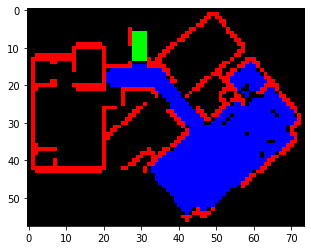

In [66]:
plt.imshow(align_fp(fp)[..., 0:3])

# rescale

85.0 2155
0.9930150483808918


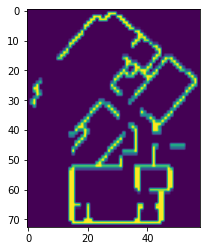

In [67]:
area = 85.0
target_ppm = 5  # pixels per meter

# indoor pixels excluding balcony
pixels = cv2.countNonZero(np.bitwise_or.reduce(fp, 2) & ~fp[:, :, 4])

print(area, pixels)

scale = sqrt(area * target_ppm ** 2 / pixels)
print(scale)

unit_scale = rescale(fp, scale, mode="edge", multichannel=True)
plt.imshow(unit_scale[:, :, 0])

In [68]:
indexes = np.where(unit_scale != 0)

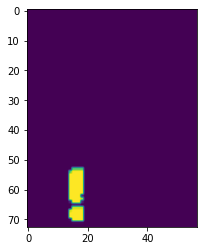

In [69]:
unit_clipped = unit_scale[
    min(indexes[0]) : max(indexes[0]) + 1, min(indexes[1]) : max(indexes[1]) + 1
]
plt.imshow(unit_clipped[:, :, 4])

In [70]:
from skimage.transform import rescale


def rescale_fp(unit_comb, area, target_ppm=5, trim=True):
    # indoor pixels excluding balcony
    pixels = cv2.countNonZero(np.bitwise_or.reduce(unit_comb, 2) & ~unit_comb[:, :, 4])
    assert pixels > 0

    scale = sqrt(area * target_ppm ** 2 / pixels)

    unit_scale = rescale(unit_comb, scale, mode="edge", multichannel=True)

    if trim:
        indexes = np.where(unit_scale != 0)
        unit_scale = unit_scale[
            min(indexes[0]) : max(indexes[0]) + 1, min(indexes[1]) : max(indexes[1]) + 1
        ]

    return (unit_scale * 255).astype(np.uint8)

rescale first